## Load Model

In [44]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import torch 
import torch.nn as nn
import time
import random 
import os
import math
import matplotlib.pyplot as plt
import keras.backend as K
from catboost import CatBoostRegressor 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [2]:
train_x = pd.read_csv('train_x_df.csv') 
train_y = pd.read_csv('train_y_df.csv') 
test_x = pd.read_csv('test_x_df.csv')
submission = pd.read_csv('sample_submission.csv')

In [5]:
train_x

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839


In [11]:
train_y

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844
...,...,...,...,...,...,...,...,...,...,...,...,...
883435,7361,115,8,1.007303,1.007845,1.007261,1.007720,2.843995e+00,686.734558,0.792856,1.373841e+00,331.730499
883436,7361,116,8,1.007678,1.008847,1.007678,1.008471,2.577599e+00,622.798462,0.884660,1.638966e+00,396.005463
883437,7361,117,8,1.008513,1.009014,1.008304,1.008805,4.579865e+00,1106.928345,1.210149,1.735705e+00,419.485596
883438,7361,118,8,1.008680,1.009222,1.008680,1.009222,1.065129e+00,257.542755,0.525789,4.348240e-01,105.134232


In [21]:
test_x

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.968750,182543.687500,332.671570,287449.968750,107758.375000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.375000,309019.750000,407.790955,560290.250000,210005.125000
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.562500,179301.843750,276.332031,214270.265625,80283.554688
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.843750,125305.117188,166.335785,56401.246094,21135.490234
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.687500,210316.796875,303.160370,138711.703125,52010.964844
...,...,...,...,...,...,...,...,...,...,...,...,...
730015,528,1375,5,1.001805,1.001805,0.998797,0.998797,583600.875000,77517.406250,473.898010,9092.824219,1210.823120
730016,528,1376,5,0.998571,1.001730,0.996690,1.001730,688827.312500,91420.523438,503.986786,289617.906250,38465.292969
730017,528,1377,5,0.999323,1.003009,0.997367,1.002934,417688.437500,55624.304688,353.542969,291073.437500,38773.152344
730018,528,1378,5,1.000903,1.000903,0.999774,0.999925,91273.515625,12139.500000,120.355049,0.000000,0.000000


## Create y_train column 

The idea is to add another column to the dataset called "close price after 2 hours". 

We will assign this column as our target column and this becomes the y_train. 

In [13]:
y_idx = 0 # row we are referring to for train_y for getting the close price for the next 2 hrs
close_after_2hrs = [] 
for i in tqdm(range(train_x.shape[0]), position = 0, leave = True): 
    if train_x.iloc[i,1] + 120 < 1380:
        close_price = train_x.iloc[i+120,6] # 6 is the index of the close price 
        close_after_2hrs.append(close_price) 
    elif train_x.iloc[i,1] + 120 >= 1380: 
        ## we need to obtain information from train_y dataframe
        close_price = train_y.iloc[y_idx, 6]
        close_after_2hrs.append(close_price) 
        y_idx += 1 
        
        
close_after_2hrs = np.asarray(close_after_2hrs) 
close_after_2hrs.shape

100%|██████████| 10159560/10159560 [09:38<00:00, 17573.09it/s]


(10159560,)

In [14]:
train_x['price_after_2hrs'] = close_after_2hrs 

train_x.head()  

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,price_after_2hrs
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,0.997450
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,0.997058
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,0.997058
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,0.997646
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,0.997842


In [15]:
## split into X_train and y_train 
X_train = train_x.drop(columns=['sample_id', 'price_after_2hrs'])  
Y_train = train_x['price_after_2hrs'] 

X_train.shape, Y_train.shape

((10159560, 11), (10159560,))

## Define CatBoost Model

We define the model and train the model as well. 

In [19]:
## We perform a 5 fold cross validation 
k = 5 
models = [] 
kfold = KFold(n_splits = k, shuffle = True, random_state = 20210319) 
for n_fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, Y_train)):  
    
    print("validating on fold {}".format(n_fold + 1)) 
    
    cur_train_x, cur_val_x = X_train.loc[train_idx,:], X_train.loc[val_idx,:]
    cur_train_y, cur_val_y = Y_train.loc[train_idx], Y_train.loc[val_idx] 
    
    ## below are randomly selected hyperparameters 
    model = CatBoostRegressor(iterations = 10000, 
                               learning_rate = 0.01, 
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               loss_function = 'RMSE',
                               eval_metric = 'RMSE',
                               use_best_model = True, 
                               task_type = 'GPU',
                               verbose = 100,
                               random_seed = 88888)  
    
    
    model.fit(cur_train_x, cur_train_y, eval_set = (cur_val_x, cur_val_y))  
    
    models.append(model)


validating on fold 1


0:	learn: 0.0351790	test: 0.0351458	best: 0.0351458 (0)	total: 33ms	remaining: 5m 29s
100:	learn: 0.0207763	test: 0.0207782	best: 0.0207782 (100)	total: 2.87s	remaining: 4m 41s
200:	learn: 0.0173548	test: 0.0173720	best: 0.0173720 (200)	total: 5.67s	remaining: 4m 36s
300:	learn: 0.0166615	test: 0.0166839	best: 0.0166839 (300)	total: 8.46s	remaining: 4m 32s
400:	learn: 0.0164395	test: 0.0164638	best: 0.0164638 (400)	total: 11.2s	remaining: 4m 27s
500:	learn: 0.0163315	test: 0.0163564	best: 0.0163564 (500)	total: 14s	remaining: 4m 25s
600:	learn: 0.0162725	test: 0.0162967	best: 0.0162967 (600)	total: 16.8s	remaining: 4m 23s
700:	learn: 0.0162543	test: 0.0162781	best: 0.0162781 (700)	total: 19.6s	remaining: 4m 19s
800:	learn: 0.0162460	test: 0.0162698	best: 0.0162698 (800)	total: 22.3s	remaining: 4m 16s
900:	learn: 0.0162427	test: 0.0162665	best: 0.0162665 (900)	total: 25.2s	remaining: 4m 14s
1000:	learn: 0.0162404	test: 0.0162643	best: 0.0162643 (1000)	total: 28s	remaining: 4m 11s
1100:	

8900:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 12s	remaining: 31.2s
9000:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 15s	remaining: 28.4s
9100:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 18s	remaining: 25.5s
9200:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 21s	remaining: 22.7s
9300:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 24s	remaining: 19.8s
9400:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 26s	remaining: 17s
9500:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 29s	remaining: 14.2s
9600:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 32s	remaining: 11.3s
9700:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 35s	remaining: 8.49s
9800:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 38s	remaining: 5.65s
9900:	learn: 0.0162327	test: 0.0162569	best: 0.0162569 (2019)	total: 4m 

7600:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 38s	remaining: 1m 9s
7700:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 41s	remaining: 1m 6s
7800:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 44s	remaining: 1m 3s
7900:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 47s	remaining: 1m
8000:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 50s	remaining: 57.6s
8100:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 53s	remaining: 54.7s
8200:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 56s	remaining: 51.8s
8300:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 3m 58s	remaining: 48.9s
8400:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 4m 1s	remaining: 46s
8500:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 4m 4s	remaining: 43.1s
8600:	learn: 0.0162936	test: 0.0162179	best: 0.0162179 (1658)	total: 4m 7s	re

6300:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 8s	remaining: 1m 50s
6400:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 11s	remaining: 1m 47s
6500:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 14s	remaining: 1m 44s
6600:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 17s	remaining: 1m 41s
6700:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 20s	remaining: 1m 38s
6800:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 23s	remaining: 1m 35s
6900:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 26s	remaining: 1m 32s
7000:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 29s	remaining: 1m 29s
7100:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 32s	remaining: 1m 26s
7200:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)	total: 3m 35s	remaining: 1m 23s
7300:	learn: 0.0162992	test: 0.0163078	best: 0.0163074 (1824)

5000:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 18s	remaining: 2m 18s
5100:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 21s	remaining: 2m 15s
5200:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 24s	remaining: 2m 13s
5300:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 26s	remaining: 2m 10s
5400:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 29s	remaining: 2m 7s
5500:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 32s	remaining: 2m 4s
5600:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 35s	remaining: 2m 1s
5700:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 38s	remaining: 1m 59s
5800:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 40s	remaining: 1m 56s
5900:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	total: 2m 43s	remaining: 1m 53s
6000:	learn: 0.0162637	test: 0.0162106	best: 0.0162106 (1703)	t

3700:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 43s	remaining: 2m 55s
3800:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 45s	remaining: 2m 52s
3900:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 48s	remaining: 2m 50s
4000:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 51s	remaining: 2m 47s
4100:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 54s	remaining: 2m 44s
4200:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 1m 57s	remaining: 2m 41s
4300:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 2m	remaining: 2m 39s
4400:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 2m 2s	remaining: 2m 36s
4500:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 2m 5s	remaining: 2m 33s
4600:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total: 2m 8s	remaining: 2m 30s
4700:	learn: 0.0159260	test: 0.0160246	best: 0.0160246 (1517)	total

In [23]:
## make prediction 
X_test = test_x.drop(columns = ['sample_id']) 

preds = [] 
for model in models: 
    pred = model.predict(X_test) 
    preds.append(pred)

In [31]:
## 5 fold ensemble 
pred_avg = (preds[0] + preds[1] + preds[2] + preds[3] + preds[4]) / 5.0 

## Visualize plots

In [59]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    # plt.axhline(1, c = 'red')
    plt.legend()


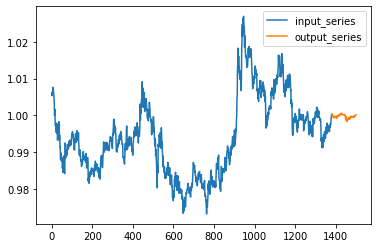

In [60]:
plot_series(X_test.iloc[0:1380, 5],pred_avg[1380-120:1380])

## Make Prediction

In [75]:
## obtain prices for the next 2 hours
next_2hrs = [] 

for i in range(529): 
    next_2hrs.append(pred_avg[1380*(i+1)-120: 1380*(i+1)]) 

In [76]:
next_2hrs = np.asarray(next_2hrs) 
next_2hrs.shape

(529, 120)

In [79]:
bq = [] 
st = [] 
for i in range(529): 
    maxval = np.max(next_2hrs[i]) 
    sell_time = np.argmax(next_2hrs[i]) 
    if maxval > X_test.iloc[1379*(i+1),5]: 
        buy_quantity = 1 
    else: 
        buy_quantity = 0 
    
    bq.append(buy_quantity) 
    st.append(sell_time)

In [81]:
submission.iloc[:,1] = bq 
submission.iloc[:,2] = st

In [83]:
submission.head()

,sample_id,buy_quantity,sell_time
0,0,1,46
1,1,1,7
2,2,1,9
3,3,1,42
4,4,1,118
